```{index} single: Pyomo; block
```
```{index} single: application; production planning
```
```{index} single: solver; cbc
```
```{index} single: Pyomo; persistent solvers
```
```{index} robust optimization
```
```{index} two-stage problem
```

# Robust Production Planning

The purpose of this notebook is to demonstrate a range of techniques for robust optimization using a common example.
* Robust Optimization (including Constraint and Column Generation of Section 10.1)
* Stochastic Optimization (including the SAA method)

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()

pyomo was previously installed


True

## Problem Statement

Consider again the initial problem of this textbook where a small startup company has announced the initial production of two models, $U$ and $V$. For completeness we re-tell the situation here with the additional layer of uncertainty:

* Model $U$ is the higher priced version requiring 10 units of raw material. The labor requirement is estimated to be 1 hour of labor A and 2 hours of labor B. The $U$ model will sell for 270€ per unit.

* Model $V$ requires 9 units of the same raw materials and is estimated to require 1 hour of labor A and 1 hour of labor B. Model $V$ sells for 210€ per unit with unlimited demand.

* A pre-production  marketing campaign offers guaranteed delivery of model $U$ in return for a down payment. Initially it is expected that the number of such orders will be 20 units. Because of the higher price, the demand for model $U$ is limited so no more than 40 units will be produced.

* The raw materials cost 10€ per unit. The raw materials have a long lead time and must be ordered now. Unused raw materials have no waste value. 

* Given current staffing, there are 80 hours of labor A available at a cost of 50€/hour, and 100 hours of labor B available at a cost of 40€/hour.

* The company will not have not accurate knowledge of the labor required to produce each product until production starts. The estimated amount of labor A and labor B needed for each unit produced could be off by 15% and 25%, respectively. Additionally, there is uncertainty about the amount of down-payment demand for model $U$ - it can differ by up to 25%, up or down, from the nominal value of 20. It is not expected, however, that more than two of those parameters are perturbed by their maximum amount.

The company's chief operating officer (COO) must decide how much raw material to order now without complete information about labor needed to manufacture the models, or knowledge about the outcome of the pre-production marketing campaign. If the COO orders too much now then raw material will be left over and wasted. If the COO orders too little then a profit opportunity will be lost. In either case, the profit realized will be less than than the potential. In what way can the best decision be made?

## What kind of a problem is this

The first thing we notice about the problem is that it has a two-stage structure: the ordering of the raw material has to be done before the unknown demand is observed and the labor requirements are known. The decisions about the amount of two models to be produced can be, however, made with full information about the uncertainty.

As for the uncertainty itself, no information is given other than the set of values the respective parameters can take:
* $z_A$: Relative uncertainty in the amount of labor A required to produce each unit of product.
* $z_B$: Relative uncertainty is the amount of labor B required to produce each unit of product.
* $z_D$: Uncertainty in number initial orders for product $U$.
where

\begin{align*}
|z_A| & \leq 0.15 && \pm\text{15% uncertainty in Labor }A \\
|z_B| & \leq 0.25 && \pm\text{25% uncertainty in Labor }B \\
|z_D| & \leq 0.25 &&  \text{25% uncertainty in initial orders for }U \\
\end{align*}

and where at most two of them attain their maximum deviation which can be formulated as the following budget constraint:

\begin{align*}
\frac{|z_A|}{0.15} + \frac{|z_A|}{0.25} + \frac{|z_D|}{0.25} \leq 2
\end{align*}

Let us see how these parameters $z_A$ and $z_B$ affect the problem.  After subtracting the unknown labor cost from the selling price, the unit profit for each device is given by:

\begin{align*}
P_U & = 270 - 50(1+z_A) - 80(1+z_B) - 100) \\
& = 40 - 50 z_A - 80 z_B \\
\implies P_U & \in [2.5, 57.5] \\
\\
P_V & = 210 - 50(1+z_A) - 40(1+z_B) - 90) \\
& = 30 - 50 z_A - 40 z_B \\
\implies P_V  & \in [12.5, 47.5]
\end{align*}

It is therefore not clear in advance which of the products would be more profitable. Taking into account the additional uncertainty about the preorder demand for product $U$, it is not possible to determine in advance what is the worst-case outcome of the uncertainty $z_A$, $z_B$, $z_D$ for this problem.

Since we don't have any information about the probabilities with which the different outcomes of the uncertain parameters could happen, a natural approach is to solve this problem with a worst-case formulation in mind. However, for sake of completeness, we also investigate how the optimal solution would look if each each realization of $(z_A, z_B, z_D)$ was equally probable.

## Two stage formulation (cf. Section 10.1)

Next we formulate the robust optimization problem where the objective is to maximize the worst case profit subject to constraints and uncertainty. We formulate the problem as

\begin{align*}
\max \quad & - 10x + \inf\limits_{z \in Z} Q(x, z) \\
\text{s.t.} \quad & x \geq 0, 
\end{align*}

where $x$ is the amount of raw material to order, and where the uncertainty $z = (z_A, z_B, z_D)$ is given by

\begin{align*}
Z = \left\{ (z_A, z_B, z_D): \ |z_A| \leq 0.15, \ |z_B| \leq 0.25, \ |z_D| \leq 0.25, \ \frac{|z_A|}{0.15} + \frac{|z_A|}{0.25} + \frac{|z_D|}{0.25} \leq 2 \right\}
\end{align*}

$Q(x, z)$ is the second-stage profit defined by

\begin{align*}
Q(x, z) = \min \quad & y_3 \\
\text{s.t.}\quad & (140 - 50z_A - 80z_B) y_1 + (120 - 50z_A - 40z_B) y_2 \geq y_3 && \text{(worst-case profit)} \\
& y_1 \geq 20 (1 + z_D) && \text{(pre-production orders)} \\
& y_2 \leq 40 && \text{(maximum demand for $U$)}\\
& (1 + z_A) y_1 + (1 + z_B) y_2 \leq 80 && \text{(labor A)} \\
& 2 (1 + z_A) y_1 + (1 + z_B) y_2 \leq 100 && \text{(labor B)} \\
& -x + 10 y_1 + 9 y_2 \leq 0 && \text{(raw materials)} \\
& y_1, y_2, y_3 \geq 0
\end{align*}

The extra decision variable $y_3$ serves the purpose of keeping the objective of the second-stage problem free of uncertainty. Clearly, $x$ plays the role of the first-stage variable here, whereas $y_1, y_2, y_3$ are the second stage variables. Using our textbook notation, we can formulate the problem data as:

\begin{align*}
x = \begin{pmatrix} x \end{pmatrix},
\
y = \begin{pmatrix} y_1 \\ y_2 \\ y_3 \end{pmatrix},
\
z = \begin{pmatrix} z_A \\ z_B \\ z_D \end{pmatrix}
\end{align*}

Then following are the definitions of the data matrices as functions of uncertainties, consistently with the notation used in Section 10.1.
\begin{align*}
c = \begin{pmatrix} -10 \end{pmatrix}, \
q = \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix} \\
\end{align*}

\begin{align*}
R(z)  = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ -1 \end{pmatrix}, 
\
S(z) = \begin{pmatrix} - (140 - 50z_A - 80z_B) & - (120 - 50z_A - 40z_B) & 1 \\ 1 & 0 & 0 \\ 1+z_A & 1 + z_A & 0 \\ 2(1+z_B) & 1 + z_B & 0 \\ 10 & 9 & 0 \end{pmatrix},
\
t(z) = \begin{pmatrix} 0 \\ -20(1+z_D) \\ 80 \\ 100 \\ 0 \end{pmatrix} \\
\end{align*}

# Solving the robust problem through random scenarios

Before diving into the CCG algorithm as described in the chapter, we can do something very simple - to sample a large number of realizations of $z$ from the set $Z$ and to solve the two-stage problem using our function above. This is done by the following code snippet.

Now, how can we actually solve a two-stage problem like this if it is indeed the worst-case profit that we are interested in? We notice that the matrix $D(z)$ depends on $z$ and therefore, we cannot easily formulate the second-stage decisions as linear functions of $z$ (linear decision rules). However, we can apply the column-and-constraint generation approach where we would gradually build a finite list of scenarios and solve a problem that will maximize the worst-case profit across such a set of scenarios:

\begin{align*}
\max \ & c^\top x + \tau  \\ 
\text{s.t.} \  & q^\top y^j \geq \tau, && j = 1, \ldots, k  \\
& R (z^j) x + S(z^j) y^j \leq t(z^j)  &&  j = 1, \ldots, k \\
& x, y^1, \ldots, y^k, \tau \geq 0 
\end{align*}

The following cell is a function that evaluates the system matrix coefficients for a particular $z\in Z$ and returns numerical values indexed in nested dictionaries.

In [2]:
# function to return c, q, C, D, e evaluated for a scenario
def model_params(z_A=0, z_B=0, z_D=0):
    
    c = {"x": -10}

    q = {"y1": 0,
         "y2": 0,
         "y3": 1}

    R = {"profit": {"x": 0},
         "demand" : {"x": 0},
         "labor A": {"x": 0},
         "labor B": {"x": 0},
         "raw materials": {"x": -1}}

    S = {"profit": {"y1": -(140 - 50*z_A - 80*z_B), "y2": -(120 - 50*z_A - 40*z_B), "y3": 1},
         "demand": {"y1": -1, "y2": 0, "y3": 0},
         "labor A": {"y1": 1, "y2": 1 + z_A, "y3": 0},
         "labor B": {"y1": 2 + 2 * z_B, "y2": 1 + z_B, "y3": 0},
         "raw materials": {"y1": 10, "y2": 9, "y3": 0}}

    t = {"profit": 0,
          "demand": -20 * (1 + z_D),
          "labor A": 80,
          "labor B": 100,
          "raw materials": 0}

    return c, q, R, S, t

c, q, R, S, t = model_params()

print(f"c = {c}")
print(f"q = {q}")
print(f"R = {R}")
print(f"S = {S}")
print(f"t = {t}")

c = {'x': -10}
q = {'y1': 0, 'y2': 0, 'y3': 1}
R = {'profit': {'x': 0}, 'demand': {'x': 0}, 'labor A': {'x': 0}, 'labor B': {'x': 0}, 'raw materials': {'x': -1}}
S = {'profit': {'y1': -140, 'y2': -120, 'y3': 1}, 'demand': {'y1': -1, 'y2': 0, 'y3': 0}, 'labor A': {'y1': 1, 'y2': 1, 'y3': 0}, 'labor B': {'y1': 2, 'y2': 1, 'y3': 0}, 'raw materials': {'y1': 10, 'y2': 9, 'y3': 0}}
t = {'profit': 0, 'demand': -20, 'labor A': 80, 'labor B': 100, 'raw materials': 0}


In the following cell we randomly sample 1000 scenarios from the uncertainty set. 

In [8]:
# import numpy as np

def z_sample():
    while True:
        sample = {
            "z_A": 0.15*np.random.uniform(-1, 1),
            "z_B": 0.25*np.random.uniform(-1, 1),
            "z_D": 0.25*np.random.uniform(-1, 1)
        }
        if( sample["z_A"] / 0.15 + sample["z_B"] / 0.25 + sample["z_D"] / 0.25) <= 2:
            break
    return sample

k = 1000
Z = [z_sample() for _ in range(k)]

The next cell creates a Pyomo model to maximize the worst case profit for a set of scenarios, where the block structure is used to repeat the parts of the model which are structurally identical for each outcome of $z$.

In [24]:
import pyomo.environ as pyo
import numpy as np

def max_min_profit(model_params, Z):
    m = pyo.ConcreteModel()

    # first stage variables
    c, q, *_ = model_params()
    
    m.I = pyo.Set(initialize=c.keys())
    m.J = pyo.Set(initialize=q.keys())
    
    m.x = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.t = pyo.Var()
    
    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))
    
    @m.Block(m.SCENARIOS)
    def scenario(b, s):

        # get model parameters for the scenario
        c, q, R, S, t = model_params(**Z[s])
        
        # second stage variables
        b.y = pyo.Var(b.model().J, domain=pyo.NonNegativeReals)

        @b.Constraint()
        def stage_net_profit(b):
            return b.y["y3"] >= b.model().t

        @b.Constraint(S.keys())
        def model_constraints(b, k):
            return  sum(R[k][i]*b.model().x[i] for i in b.model().I) + sum(S[k][j]*b.y[j] for j in b.model().J) <= t[k]
    
    # worst case profit
    @m.Objective(sense=pyo.maximize)
    def min_profit(m):
        return sum(c[i] * m.x[i] for i in c.keys()) + m.t
    
    solver = pyo.SolverFactory('cbc')
    solver.solve(m)
    return m

print("\nSolution to the nominal problem\n")
m = max_min_profit(model_params, [{"z_A": 0, "z_B":0, "z_D": 0}])
m.min_profit.display()
m.x.display()

print("\nSolution to the robust problem\n")
m = max_min_profit(model_params, Z)
m.min_profit.display()
m.x.display()


Solution to the nominal problem

min_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 2600.0
x : Size=1, Index=I
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      x :     0 : 740.0 :  None : False : False : NonNegativeReals

Solution to the robust problem

min_profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 791.5401999999995
x : Size=1, Index=I
    Key : Lower : Value     : Upper : Fixed : Stale : Domain
      x :     0 : 560.41812 :  None : False : False : NonNegativeReals


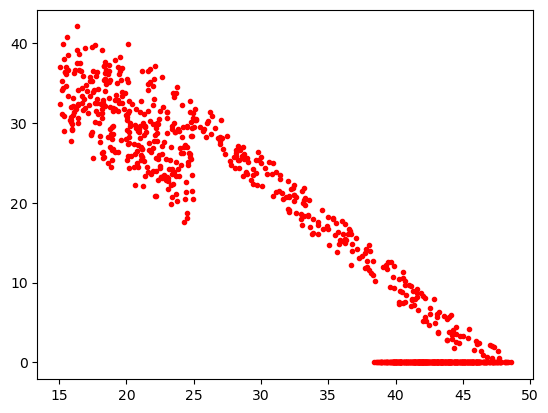

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

for s in m.SCENARIOS:
    ax.plot(m.scenario[s].y["y1"](), m.scenario[s].y["y2"](), 'r.')

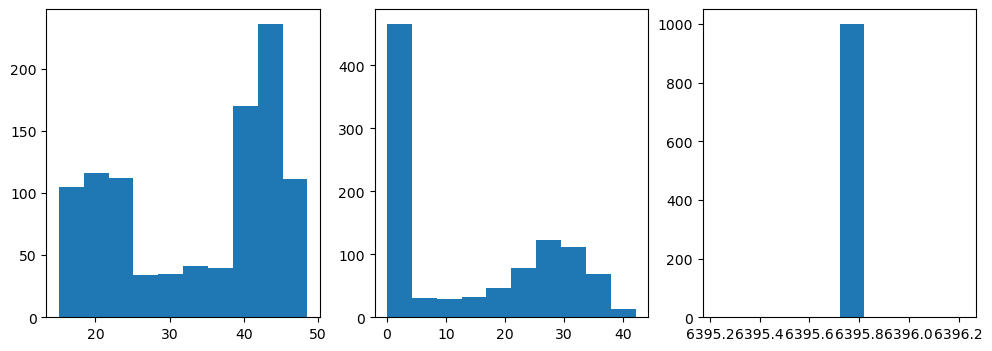

In [39]:
import matplotlib.pyplot as plt

Y = np.array([[m.scenario[s].y[j]() for j in m.J] for s in m.SCENARIOS])

fig, ax = plt.subplots(1, len(m.J), figsize=(12, 4))

for j in range(len(m.J)):
    ax[j].hist(Y[:, j])



The optimal quantity of the raw material to order is equal to $556.62$ and the worst-case profit it promises is equal to $911.28$. Apart from the worst-case profit, we can also be interested in the average-case profit. We can compute it by, for each realization of the uncertain parameter, to see what would the optimal decisions $y$ be in their case, and compute the corresponding profits. 

In [ ]:
import pyomo.environ as pyo
import numpy as np

# function that optimizes only over the second stage variables

def max_profit(model_params, Z, x):
    m = pyo.ConcreteModel()

    # first stage variables
    c, *_ = model_params()
    m.x = pyo.Var(c.keys(), domain=pyo.NonNegativeReals)
    m.t = pyo.Var()
    
    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))
    
    @m.Block(m.SCENARIOS)
    def scenario(b, s):

        # get model parameters for the scenario
        c, q, R, S, t = model_params(**Z[s])
        
        # second stage variables
        b.y = pyo.Var(q.keys(), domain=pyo.NonNegativeReals)

        @b.Constraint()
        def stage_net_profit(b):
            return b.y["y3"] >= b.model().t
        
        @b.Expression()
        def profit(b):
            return -10 * sum(b.model().x[i] for i in c.keys()) - S["profit"]["y1"] * b.y["y1"] - S["profit"]["y2"] * b.y["y2"]

        @b.Constraint(S.keys())
        def model_constraints(b, k):
            return  sum(R[k][i]*b.model().x[i] for i in c.keys()) + sum(S[k][j]*b.y[j] for j in q.keys()) <= t[k]
    
    # worst case profit
    @m.Objective(sense=pyo.maximize)
    def min_profit(m):
        return sum(c[i] * m.x[i] for i in c.keys()) + m.t
    
    solver = pyo.SolverFactory('gurobi')
    solver.solve(m)
    return m


## Comparing the worst-case optimization to expected-profit optimization

As already said, for sake of stability analysis, we may be interested in how the optimal solution changes when we do make an assuption that every outcome of uncertainty is equally probably and that we optimize for the average cost, just as in problem (10.6) in the textbook:

\begin{align}
\min\limits_{x, y^j} \ & c^\top x + \frac{1}{N} \sum\limits_{j = 1}^N q^\top y^j \\
\text{s.t.} \ & A x \leq b \\
& R ( z^j) x + S (z^j) y^j \leq t(z^j) &\  j = 1, \ldots, N.
\end{align}

The following code is a slight modification of the earlier function that optimized for the worst-case solution.

In [ ]:
import pyomo.environ as pyo
import numpy as np

def max_expected_profit(model_params, Z):
    m = pyo.ConcreteModel()

    # first stage variables
    c, *_ = model_params()
    m.x = pyo.Var(c.keys(), domain=pyo.NonNegativeReals)
    
    m.SCENARIOS = pyo.Set(initialize=range(len(Z)))
    
    @m.Block(m.SCENARIOS)
    def scenario(b, s):

        # get model parameters for the scenario
        c, q, R, S, t = model_params(**Z[s])
        
        # second stage variables
        b.y = pyo.Var(q.keys(), domain=pyo.NonNegativeReals)

        @b.Constraint(S.keys())
        def model_constraints(b, k):
            return  sum(R[k][i]*b.model().x[i] for i in c.keys()) + sum(S[k][j]*b.y[j] for j in q.keys()) <= t[k]
    
    # worst case profit
    @m.Objective(sense=pyo.maximize)
    def min_profit(m):
        return sum(c[i] * m.x[i] for i in c.keys()) + sum(m.scenario[s].y["y3"]() for s in m.SCENARIOS) / len(m.SCENARIOS)
    
    solver = pyo.SolverFactory('gurobi')
    solver.solve(m)
    return m

m = max_expected_profit(model_params, Z)
m.x.display()
m.min_profit.display()

As we can see, the optimal to-order quantity of the raw material changes to...

Of course, this is only the comparison of the two approaches by looking at the first-stage decision. One can also be interested in the following two items:
* 'average-case performance' of the optimal ordering decision of the robust solution - to find this one, one would need to fix this first-stage decision and for each of the sampled scenarios one would need to optimize the second-stage decisions, taking the average of their costs in the end. It is expected that the robust solution yields a slightly worse average-case performance than the stochastic one.
* 'worst-case performance' of the optimal ordering decision of the robust solution - to find this, one would need to use a function like the one we used to solve the robust solution, but fixing the first-stage decision to be the one obtained from the stochastic solution. In this way, the optimal worst-case second stage cost is computed, and the overall worst-case cost is expected to be slightly worse than that of the robust solution.

We leave coding the relevant (minor) parts to perform the above analysis to the reader as an exercise.

Finally, we are ready to introduce the column-and-constraint generation approach of this chapter.

## Column and constraint generation for the robust solution

The downside of the approach of sampling many scenarios and solving the max-min optimization problem just as before is that it requires really many scenarios to be reasonably sure that we cover most of the extreme outcomes of $z$. This is exactly an issue that the CCG algorithm is supposed to mitigate against - the idea is to gradually build a list of scenarios that are `bad' and hopefully, end up with solving a problem with far less than 1000 problem copies included.

In the pessimization step of the CCG, having solved problem \ref{ch10:complete.example.ccg.master} we want to find a new realization $z$ where for each $i$, at least one of the rows in the constraint system
\begin{align*}
C(z^i) \bar{x} + D(z^i) \bar{y}^i \leq e(z^i)
\end{align*}
is violated. If we expand the terms in each of the rows and rewrite the constraints into a form that makes them easier to read as constraints on $z_A$, $z_B$, $z_D$, then we obtain that for each $i$, at least one of the four following has to hold:
\begin{align*}
(50 \bar{y}^i_1 + 50 \bar{y}^i_2) z_A + (80 \bar{y}_1^i + 40 \bar{y}_2^i) z_B & > -\bar{y}^i_3 + 140 \bar{y}^i_1 + 120 \bar{y}^i_2 && \text{(profit)} \\
20 z_D & > \bar{y}_1^i - 20 && \text{(demand)} \\
(y_1^i + y_2^i) z_A & > 80 - \bar{y}_1^i - \bar{y}_2^i && \text{(labor A)} \\
(2 y_1^i + y^i_2) z_B & > 100 - 2 \bar{y}_1^i - \bar{y}_2^i && \text{(labor B)} \\
\end{align*}
Using a sufficiently large number $M$ and binary variables $u_{ik} \in \{0, 1\}$ for each of them, we can formulate the problem of searching for an infeasible scenario as
\begin{align*}
\max \ & \theta \\
\text{s.t.} \ &  (50 \bar{y}^i_1 + 50 y_2) z_A + (80 \bar{y}^i_1 + 40 \bar{y}^i_2) z_B - \theta \geq -\bar{y}_3^i + 140 \bar{y}_1^i + 120 \bar{y}_2^i - M u_{i1} && \forall j \\
& 20 z_D - \theta \geq \bar{y}_1^i - 20 - M u_{i2} && \forall j \\
& (\bar{y}_1^i + \bar{y}_2^i) z_A - \theta \geq 80 - \bar{y}_1^i - \bar{y}_2^i - M u_{i3} && \forall j \\
& (2 \bar{y}_1^i + \bar{y}^i_2) z_B 100 - 2 \bar{y}_1^i - \bar{y}_2^i  - M u_{i4} && \forall j \\
& \sum_{k = 1}^4 u_{ik} \leq 3 && \forall j \\
& \theta \geq 0 \\
& u_{jk} \in \{ 0, 1\} && \forall j, k
\end{align*}
The following code snippet defines the data matrices needed to solve the above problem based on a list of first- and second-stage optimal variables from \ref{ch10:complete.example.ccg.master}.

In [12]:
def subproblem_params(dec):

    Left = {"demand" : {"z_A": 0, "z_B": 0, "z_D": 20},
            "profit": {"z_A": (50 * dec["y1"] + 50 * dec["y2"]), "z_B": (80 * dec["y1"] + 40 * dec["y2"]), "z_D": 0},
             "labor A": {"z_A": dec["y1"] + dec["y2"], "z_B": 0, "z_D": 0},
             "labor B": {"z_A": 0, "z_B": 2 * dec["y1"] + dec["y2"], "z_D": 0}}

    Right = {"demand": dec["y1"] - 20,
             "profit": 140 * dec["y1"] + 120 * dec["y2"] - dec["y3"],
              "labor A": 80 - dec["y1"] - dec["y2"],
              "labor B": 100 - 2 * dec["y1"] - dec["y2"]}

    return Left, Right

The next code uses the above function to formulate the pessimization problem, where for extra flexibility we have included tha maximum values of the parameters deviations and the uncertainty budget as the function's arguments. In the function (see the line marked as 'hack for faster CCG convergence') we in fact look for scenarios $z$ that will make only the 'feasibility' constraints of the second-stage problem violated, without accounting for the 'profit related' proxy constraint. We do so in hope to accelerate the CCG convergence - the profit constraint will be taken care of anyway as the variable $y_3$ can adapt freely for each newly generated $z^i$ and each newly generated solution to the master problem, and at the same time, we eliminate the risk of iteratively building a list of scenarios $z$ that violate only the profit constraints across all $i$, without actually hurting the feasibility of the production plans made.

In [15]:
def pessimization_problem(subproblem_params, master_solution, z_A_max=0.15, z_B_max=0.25, z_D_max=0.5, Gamma=2):
    
    # Initial definitions
    m = pyo.ConcreteModel()
    big_M = 1000
    
    L, R = subproblem_params(master_solution[0])
    # indices for the variables
    m.Z_INDICES = pyo.Set(initialize=["z_A", "z_B", "z_D"])
    m.SCENARIOS = pyo.Set(initialize=range(len(master_solution)))
    
    # indices for the scenarios
    # indices for inequalities
    
    m.z = pyo.Var(m.Z_INDICES, domain=pyo.Reals)
    m.z_abs = pyo.Var(m.Z_INDICES, domain=pyo.NonNegativeReals)
    
    m.theta = pyo.Var(domain=pyo.Reals)
    
    # Constraints on z itself
    m.A_ub = pyo.Constraint(expr = m.z["z_A"] <= z_A_max)
    m.A_lb = pyo.Constraint(expr = -m.z["z_A"] <= z_A_max)
    m.A_abs = pyo.Constraint(expr = m.z["z_A"] <= m.z_abs["z_A"])
    
    m.B_lb = pyo.Constraint(expr = m.z["z_B"] <= z_B_max)
    m.B_ub = pyo.Constraint(expr = -m.z["z_B"] <= z_B_max)
    m.B_abs = pyo.Constraint(expr = m.z["z_B"] <= m.z_abs["z_B"])
    
    m.D_lb = pyo.Constraint(expr = m.z["z_D"] <= z_D_max)
    m.D_ub = pyo.Constraint(expr = -m.z["z_D"] <= z_D_max)
    m.D_abs = pyo.Constraint(expr = m.z["z_D"] <= m.z_abs["z_D"])
    
    m.z_budget = pyo.Constraint(expr = m.z_abs["z_A"]/z_A_max + m.z_abs["z_B"]/z_B_max + m.z_abs["z_D"]/z_D_max <= Gamma)
    
    #, bounds = {"z_A": (-0.15, 0.15),"z_B": (-0.25, 0.25), "z_D": (-0.5, 0.5)}
    
    # Constraint violation: blockwise
    @m.Block(m.SCENARIOS)
    def scenario(b, s):
        # get model parameters for the scenario
        L, R = subproblem_params(master_solution[s])
        
        # second stage variables
        b.u = pyo.Var(L.keys(), domain=pyo.Binary)
        
        # hack for faster CCG convergence
        @b.Constraint()
        def at_least_one_violated(b): # only care for violations related to the `actual' constraints, not the profit constraint
            return sum(b.u[k] for k in L.keys() if k != "profit") <= len(L.keys()) - 2

        @b.Constraint(L.keys())
        def model_constraints(b, k):
            return  sum(L[k][i]*b.model().z[i] for i in b.model().Z_INDICES) - b.model().theta >= R[k] - b.u[k] * big_M
    
    # worst case profit
    @m.Objective(sense=pyo.maximize)
    def max_violation(m):
        return m.theta
    
    solver = pyo.SolverFactory('gurobi')
    solver.solve(m)
    
    return m.theta(), m.z["z_A"](), m.z["z_B"](), m.z["z_D"]()

With the two functions above defined, we are ready to put them together into an implementation of the CCG algorithm. In the below code, we hard-limit the maximum number of iterations to 50 scenarios and we decide to stop the algorithm when the optimal value of the pessimization subproblem is less than 0.1 (constraint violation of 0.1 seems to be `acceptably small' given the fact that the labor availability numbers are in the magnitude of 80 and 100, and the amount of raw material purchased is also expected to be in the hundreds, just like the optimal profit).

In [13]:
# This is the code for the CCG algorithm
ccg_converged = False
stopping_precision = 0.1
max_iterations = 50
ccg_iterations = 0

# Initialize the null scenario - no perturbation
Z = [{"z_A": 0, "z_B":0, "z_D": 0}]

while((not ccg_converged) and (ccg_iterations < max_iterations)):
    
    # Building and solving the master problem
    m = max_min_profit(model_params, Z)
    
    # Exporting the data from the master problem into a list of dictionaries
    c, q, *_ = model_params()
    
    master_solution = []
        
    for s in range(len(Z)):
        single_solution = {}
        
        for x_key in c.keys():
            single_solution[x_key] = m.x[x_key]()
        
        for y_key in q.keys():
            single_solution[y_key] = m.scenario[s].y[y_key]()
            
        master_solution.append(single_solution)
    
    print(master_solution[0]["x"])
    
    # Pessimization
    theta_opt, z_A, z_B, z_D = pessimization_problem(subproblem_params, master_solution, 0.15, 0.25, 0.25, 2)
    
    # IF pessimization yields no violation, stop, otherwise add scenario
    if (theta_opt < stopping_precision):
        ccg_converged = True
    else:
        print(f"Violation found: z_A = {z_A:4.2f},  z_B = {z_B:4.2f},  z_D = {z_D:4.2f}, constraint violation: {theta_opt:6.2f}")
        Z.append({"z_A": z_A, "z_B": z_B, "z_D": z_D})
    
    ccg_iterations += 1

NameError: name 'max_min_profit' is not defined

As we can see, it takes only 5 iterations, instead of 1000 scenarios, to arrive at an `almost' robust solution which pretty much the same first-stage decisiona as in the first case.

## Deprecated

26.198683
7.0560933
0.0
20.757514
20.068052
14.827905
31.3327
9.48064
28.017703
6.2784533
17.439045
34.541082
32.33126
0.0
43.048848
31.745528
16.014391
23.863172
0.0
17.308388
28.067321
24.247131
48.600621
31.31583
45.365929
30.115037
6.4890862
13.22725
31.320777
33.915857
42.191805
16.497871
19.735968
10.734789
39.523543
11.892533
22.428385
18.980668
24.909472
20.712239
15.292546
28.815323
24.54802
9.9810791
2.737986
0.0
27.485174
50.134804
0.0
13.501614
33.912289
0.0
10.816643
2.9431181
9.2412851
34.331304
12.025608
24.151304
10.801697
16.251797
7.1420725
14.855333
0.0
13.190102
17.035114
28.074437
38.457392
33.104434
8.8997477
18.030732
34.273589
15.075443
32.923047
27.821987
48.7007
0.0
39.867193
6.9169826
16.749185
17.810623
14.425185
7.8925999
0.0
31.134832
14.866129
41.381879
28.093972
36.119335
15.594153
42.330463
31.055116
10.547169
22.67241
10.610095
30.81574
27.572791
24.727445
54.521721
38.861688
21.83798
22.566875
10.040019
4.4096529
30.646867
21.169396
27.425691
0.0
27.4

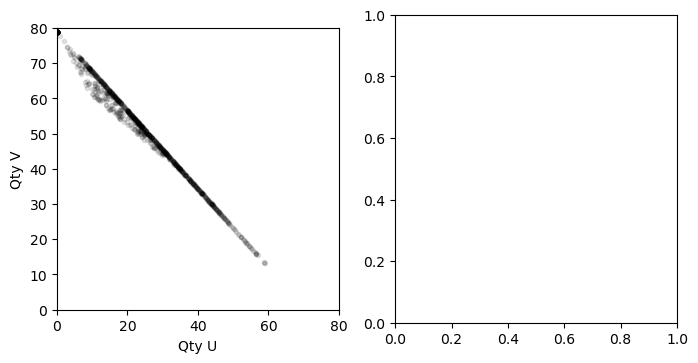

In [226]:
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(121, aspect=1, xlabel="Qty U", ylabel="Qty V", xlim=(0, 80), ylim=(0, 80))
for s in m.SCENARIOS:
    print(m.scenario[s].y["u"].value)
    ax.plot(m.scenario[s].y["u"].value, m.scenario[s].y["v"].value, 'k.', alpha=0.1)
    
ax = plt.subplot(122)


## Bibliographic Notes

* https://link.springer.com/content/pdf/10.1007/s11750-021-00593-2.pdf

* Zeng, B., & Zhao, L. (2013). Solving two-stage robust optimization problems using a column-and-constraint generation method. Operations Research Letters, 41(5), 457-461. 